# Summary of NP bioassay over the past decade

### Import modules

In [1]:
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
import json
import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

In [2]:
DATA_DIR = '../data'

# Load bioassay data

Data was generated using the get_bioassay_metadata() method in utils.

In [3]:
year_df = pd.read_csv(f'{DATA_DIR}/assay_year_data.tsv', sep='\t', usecols=['year', 'assay_id'])
year_df.set_index('assay_id', inplace=True)
year_map = year_df.to_dict()['year']

In [4]:
# Load existing assay data
assay_df = pd.read_csv(f'{DATA_DIR}/chembl_phytochemical_bioassays.tsv', sep='\t')
assay_df['year'] = assay_df['assay_id'].map(year_map)
assay_df.dropna(subset=['year'], inplace=True)
assay_df.head(2)

,chembl_id,smiles,pchembl_value,assay_id,active,year
0,CHEMBL186433,CN(C)CCCCCCOc1ccc(-n2ccnc2)cc1,8.66,CHEMBL615342,True,2004.0
1,CHEMBL35025,COc1ccc(CNC(=O)[C@@H](NC(=O)[C@H](NCc2cc(OC)c(...,7.30,CHEMBL615352,True,2002.0


# Annotate medicinal and non-medicinal compounds

In [5]:
plant_chemical_df = pd.read_csv(
    f'{DATA_DIR}/plant_chemical_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)
plant_chemical_df['cid'] = plant_chemical_df['chemical_curie'].str.split(':').str[1]
plant_chemical_df.head(2)

,plant_curie,chemical_curie,cid
0,ncbitaxon:1000425,pubchem.compound:3527,3527
1,ncbitaxon:1000425,pubchem.compound:68082,68082


In [6]:
plant_disease_df = pd.read_csv(
    f'{DATA_DIR}/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'disease_curie',
    ]
)

# Map CIDs to ChEMBL

In [7]:
chembl_mapper = json.load(open(f'{DATA_DIR}/chembl_mapper.json'))
plant_chemical_df['chembl_idx'] = plant_chemical_df['cid'].map(chembl_mapper)
plant_chemical_df.head(2)

,plant_curie,chemical_curie,cid,chembl_idx
0,ncbitaxon:1000425,pubchem.compound:3527,3527,None
1,ncbitaxon:1000425,pubchem.compound:68082,68082,CHEMBL141690


In [8]:
plant_chemical_df.cid.nunique()

87019

In [9]:
med_plants = plant_disease_df.plant_curie.unique()
len(med_plants)

6048

In [10]:
medicinal_phytochemicals = set()
non_medical_phytochemicals = set()
non_mapped = set()

for plant_curie, chemical_idx, cid, chemical_idx in tqdm(plant_chemical_df.values):
    if chemical_idx is None:
        non_mapped.add(cid)
        continue

    if plant_curie in med_plants:
        medicinal_phytochemicals.add(chemical_idx)
    else:
        non_medical_phytochemicals.add(chemical_idx)

len(medicinal_phytochemicals), len(non_medical_phytochemicals), len(non_mapped)

100%|██████████| 383591/383591 [00:34<00:00, 11190.64it/s]


(13474, 11508, 67875)

In [11]:
assay_df['compound_type'] = assay_df['chembl_id'].progress_apply(
    lambda x: 'medicinal' if x in medicinal_phytochemicals else 'non-medicinal'
)

100%|██████████| 9988/9988 [00:00<00:00, 345114.08it/s]


In [12]:
assay_df['year'] = assay_df['year'].astype(int)

In [13]:
assay_df['compound_type'].value_counts()

medicinal        7408
non-medicinal    2580
Name: compound_type, dtype: int64

# Create year count table

In [14]:
assay_year_data = []

for year in tqdm(assay_df['year'].unique()):
    tmp = assay_df[assay_df['year'] == year]

    assay_year_data.append({
        'year': year,
        'plant': 'bioassays',
        'count': tmp['assay_id'].nunique(),
    })

    assay_year_data.append({
        'year': year,
        'plant': 'compounds',
        'count': tmp['chembl_id'].nunique(),
    })
    
final_df = pd.DataFrame(assay_year_data)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 373.25it/s]


In [15]:
approved_np = pd.read_csv(f'{DATA_DIR}/newman_natural_products.tsv', sep='\t')
approved_np.head(2)

,curated_name,pubchem_name,pubchem_id,drugbank_id,synonyms,inchikey,smiles,multiple_structures,disease,year,source,structure_code,mdd_bryans,oral,parenteral,subcutaneous,intravenous,intramuscular
0,aclarubicin,"methyl (1R,2R,4S)-4-[(2R,4S,5S,6S)-4-(dimethyl...",451415,DB11617,"['aclarubicin', 'Aclacinomycin A', '57576-44-0...",USZYSDMBJDPRIF-SVEJIMAYSA-N,CC[C@]1(C[C@@H](C2=C(C3=C(C=C2[C@H]1C(=O)OC)C(...,False,anticancer,1981,unaltered natural product,N,NaN,NaN,NaN,NaN,NaN,NaN
1,Netilmicin sulfate,"(2R,3R,4R,5R)-2-[(1S,2S,3R,4S,6R)-4-amino-3-[[...",62115,NaN,"['NETILMICIN SULFATE', 'Netromycin', 'Netillin...",AGFWIZQEWFGATK-UNZHCMSXSA-N,CCN[C@@H]1C[C@@H]([C@H]([C@@H]([C@H]1O[C@@H]2[...,True,antibacterial,1981,unaltered natural product,N,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
approved_data = []

for year in tqdm(approved_np['year'].unique()):
    tmp = approved_np[approved_np['year'] == year]

    approved_data.append({
        'year': year,
        'plant': 'approved_drugs',
        'count': tmp['inchikey'].nunique(),
    })

    
approved_df = pd.DataFrame(approved_data)

  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:00<00:00, 469.96it/s]


# Visualize the plot

In [17]:
palette = sns.color_palette('hls', n_colors=3)

/var/folders/61/bn_r735d70z03hg56wh7hsg80000gn/T/ipykernel_60902/3087302360.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


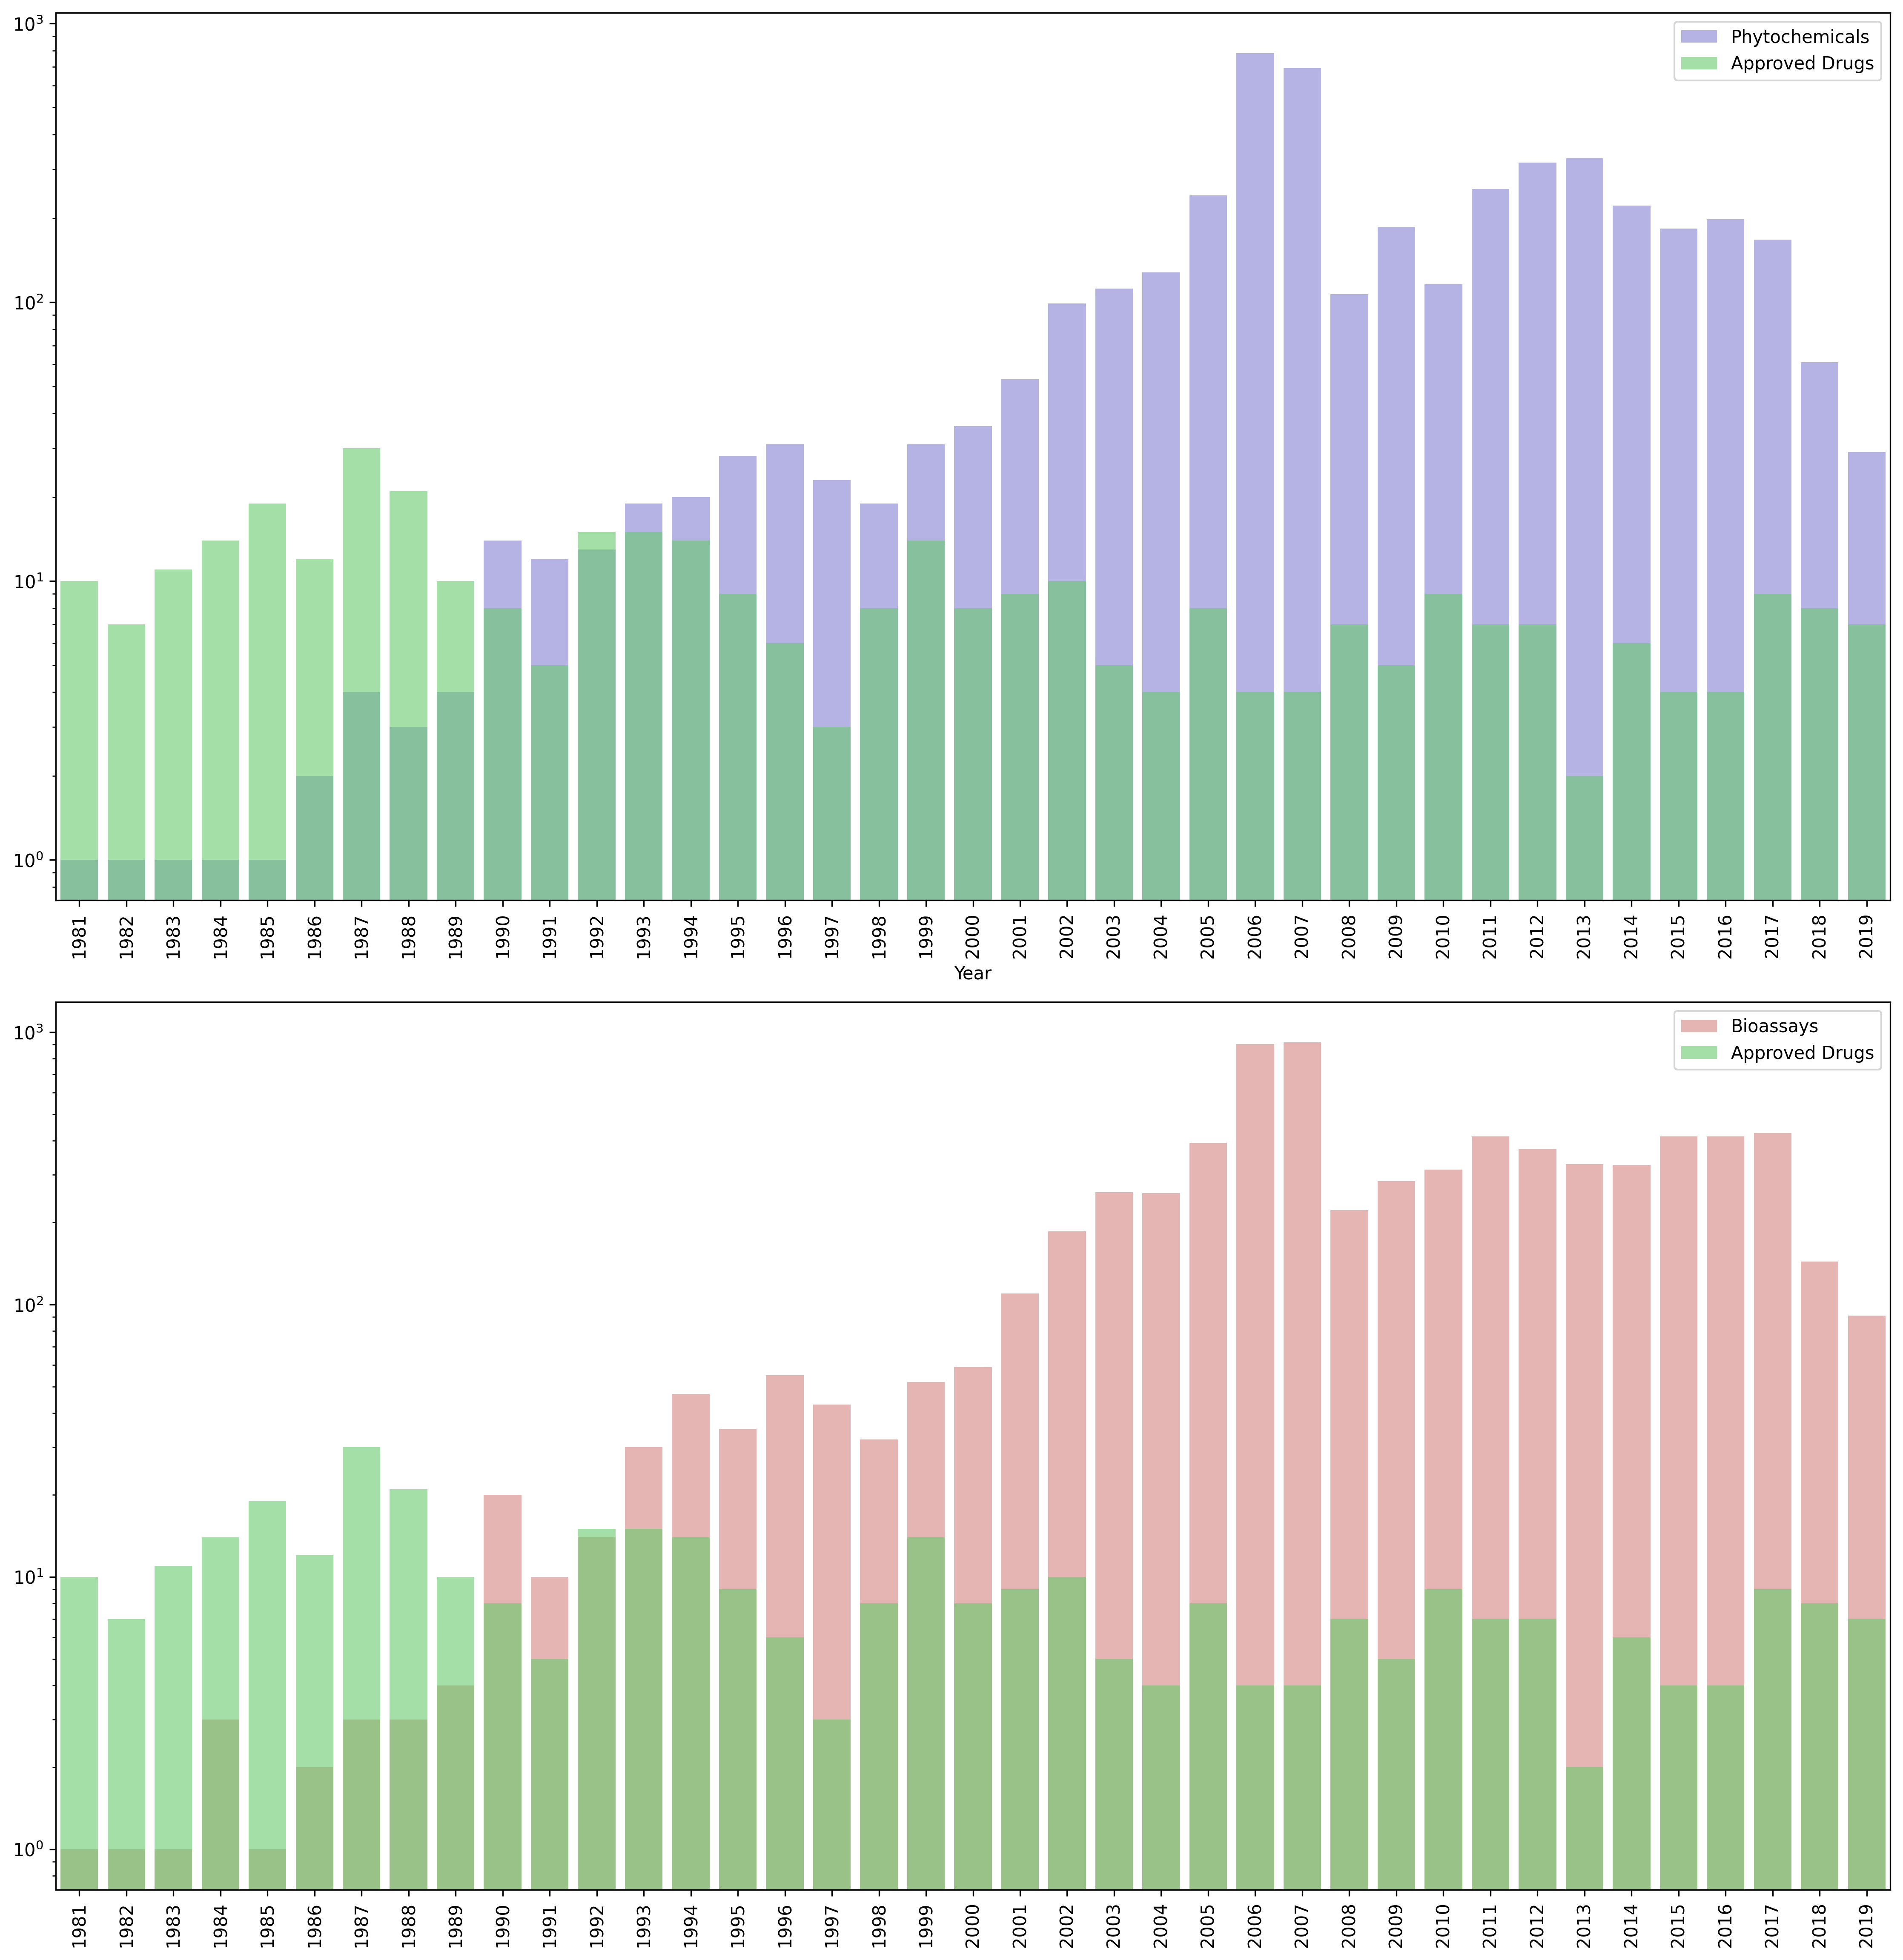

In [18]:
plt.figure(dpi=300, figsize=([15,15]))

plt.subplots_adjust(wspace=0)

plt.title('Bioassays and Compounds per Year')

plt.subplot(2,1,1)
k = final_df[final_df['plant'] == 'compounds']
sns.barplot(
    data=k, x='year', y='count', palette=[palette[2]], alpha=0.5, label='Phytochemicals'
)
sns.barplot(
    data=approved_df, x='year', y='count', palette=[palette[1]], alpha=0.6, label='Approved Drugs'
)
plt.xlabel('Year')
plt.legend()
plt.ylabel('')
plt.yscale('log')
plt.xticks(rotation=90)
plt.tight_layout()

plt.subplot(2,1,2)
k = final_df[final_df['plant'] == 'bioassays']
sns.barplot(
    data=k, x='year', y='count', palette=[palette[0]], alpha=0.5, label='Bioassays'
)
sns.barplot(
    data=approved_df, x='year', y='count', palette=[palette[1]], alpha=0.6, label='Approved Drugs'
)
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('')
plt.yscale('log')
plt.ylabel('')

plt.savefig(f'../figures/supplementary_figure_6.png', bbox_inches='tight', dpi=400)

plt.show()